## 1. Importing Libraries


In [1]:
import pandas as pd
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,  accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

## 2. Loading and Exploring the Data

In [2]:
train = pd.read_csv('data/fraud_email_train.csv',low_memory=False)
test = pd.read_csv("data/fraud_email_test.csv",low_memory=False)

In [3]:
train.head()
train.describe()
train.info
train.columns

Index(['Folder-User', 'Folder-Name', 'Message-ID', 'Date', 'From', 'To',
       'Subject', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding',
       'X-From', 'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName',
       'Body', 'Cc', 'Bcc', 'Time', 'Attendees', 'Re', 'Source', 'Mail-ID',
       'POI-Present', 'Suspicious-Folders', 'Sender-Type',
       'Unique-Mails-From-Sender', 'Low-Comm', 'Contains-Reply-Forwards',
       'Label'],
      dtype='object')

In [4]:
print(train['Label'].value_counts())
print(test['Label'].value_counts())

Label
0    356073
1      1860
Name: count, dtype: int64
Label
0    89017
1      467
Name: count, dtype: int64


## 3. Data Cleaning and Preparation

### Concat and create a new column called `id`

In [5]:
train['id'] = 'train'
test['id'] = 'test'

data = pd.concat([train,test])

### Slicing important columns from data 

In [6]:
data = data[['From', 'To', 'Subject', 'Body', 'Bcc', 'Label','id']]

### Reformatting `From` and `To`

In [7]:
data.loc[:,'From'] = data['From'].str.replace('.', ' ').str.replace('@', ' ').str.replace('com', '')
data.loc[:,'To'] = data['To'].str.replace('.', ' ').str.replace('@', ' ').str.replace('com', '')

### Creating new column: `text`

In [8]:
data['text'] =  data['Subject'] + ' ' + data['From'] + ' ' + data['To'] + ' ' + data['Bcc'] + ' ' + data['Body']

data.drop(columns=['From','Body','To','Bcc','Subject'],inplace=True)

### Convert `text` to string

In [9]:
data['text'] = data['text'].apply(lambda x: str(x) if not pd.isna(x) else np.nan)

### Delete `punctuation`

In [10]:
data['text'] = data['text'].str.lower().replace(f'[{punctuation}]','',regex=True)

### Split in `train` and `test`

In [11]:
train = data[data['id']=='train'].drop(columns='id')
test = data[data['id']=='test'].drop(columns='id')

### Drop duplicated values

In [12]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

### Dealing with missing values

In [13]:
pre_tfidf = TfidfVectorizer(stop_words='english',max_features=5000)

train_0 = train.loc[train['Label']==0,'text']
test_0 = test.loc[test['Label']==0,'text']
train_1 = train.loc[train['Label']==1,'text']
test_1 = test.loc[test['Label']==1,'text']

temp_train_1 = train_1.dropna()
pre_tfidf.fit(temp_train_1)

fill_0 = ' '.join(pre_tfidf.get_feature_names_out())

train.loc[train['Label']==0,'text'] = train_0.fillna(fill_0)
test.loc[((test['text'].isna()) & (test['Label']==0) ),'text'] = test_0.fillna(fill_0)


train.loc[train['Label']==1,'text'] = train_1.fillna(fill_0)
test.loc[((test['text'].isna()) & (test['Label']==1) ),'text'] = test_1.fillna(fill_0)

## 4. Splitting and Vectorizing Data

In [14]:
x_train = train.drop(columns='Label')
y_train = train['Label'] 
x_test = test.drop(columns='Label')
y_test = test['Label']

### CountVectorizer

In [15]:
vectorizer = CountVectorizer(stop_words='english')

x_train_vecto = vectorizer.fit_transform(x_train['text'])
x_test_vecto = vectorizer.transform(x_test['text'])

### TfidfVectorizer

In [16]:
tfidf = TfidfVectorizer(stop_words='english')

x_train_tfidf = tfidf.fit_transform(x_train['text'])
x_test_tfidf = tfidf.transform(x_test['text'])

## 5. Model Building and Training


In [17]:
model_description = []

def save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration):
    
    accuracy = accuracy_score(y_test,predictions)
    precision = precision_score(y_test,predictions)
    recall = recall_score(y_test,predictions)
    f1score = f1_score(y_test,predictions)
    cm = confusion_matrix(y_test,predictions)
    
    model_description.append([model_name,accuracy,precision,recall,f1score,train_duration,predict_duration,cm])
    disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(model_name)
    plt.show()

### Naive Bayes

#### MultinomialNB with CountVectorizer

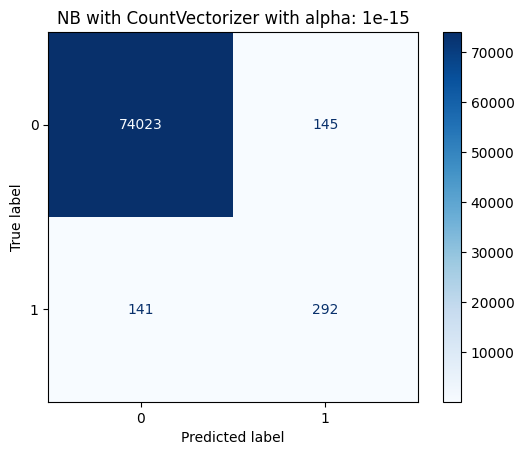

In [46]:
model = MultinomialNB(alpha=1e-15)

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time


start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = f'NB with CountVectorizer with alpha: 1e-15'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### MultinomialNB with TfidfVectorizer

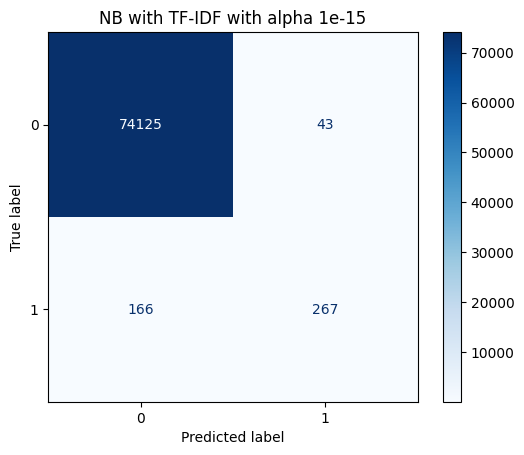

In [19]:
model = MultinomialNB(alpha=1e-15)

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'NB with TF-IDF with alpha 1e-15'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

### Decision Trees

#### Decision Trees: entropy | CountVectorizer

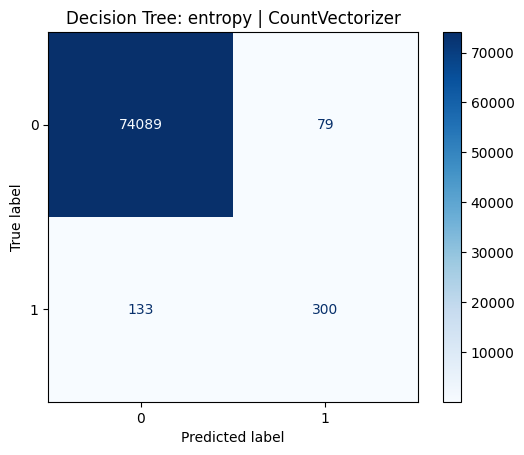

In [20]:
model = DecisionTreeClassifier(criterion='entropy')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: entropy | CountVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Tree: entropy-balanced | CountVectorizer

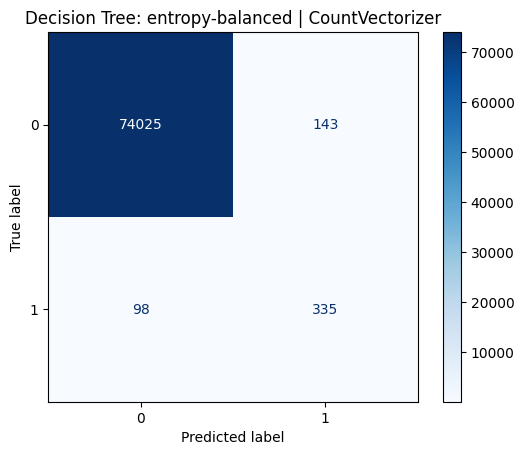

In [21]:
model = DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: entropy-balanced | CountVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Trees: entropy | TfidfVectorizer

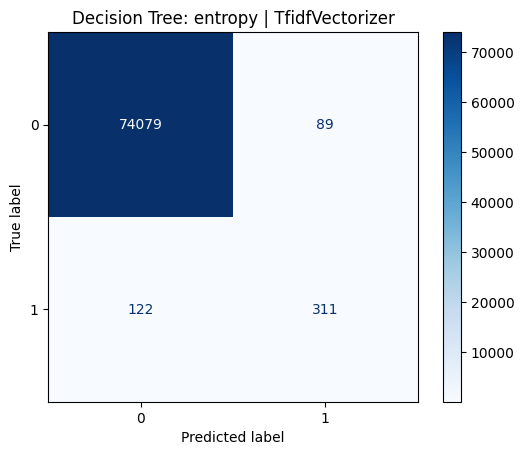

In [22]:
model = DecisionTreeClassifier(criterion='entropy')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: entropy | TfidfVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Trees: entropy-balanced | TfidfVectorizer

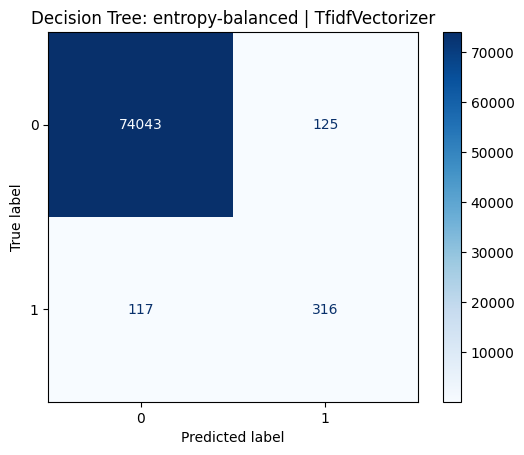

In [23]:
model = DecisionTreeClassifier(criterion='entropy',class_weight='balanced')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: entropy-balanced | TfidfVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Trees: gini | CountVectorizer

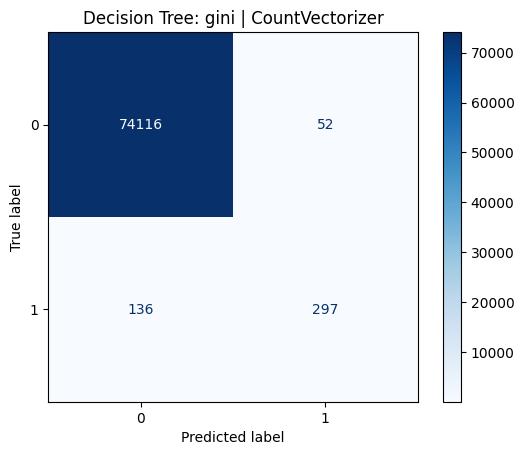

In [24]:
model = DecisionTreeClassifier(criterion='gini')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: gini | CountVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Tree: gini-balanced | CountVectorizer

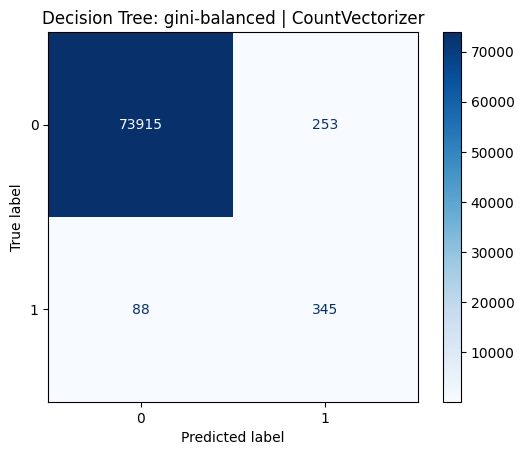

In [25]:
model = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: gini-balanced | CountVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Trees: gini | TfidfVectorizer

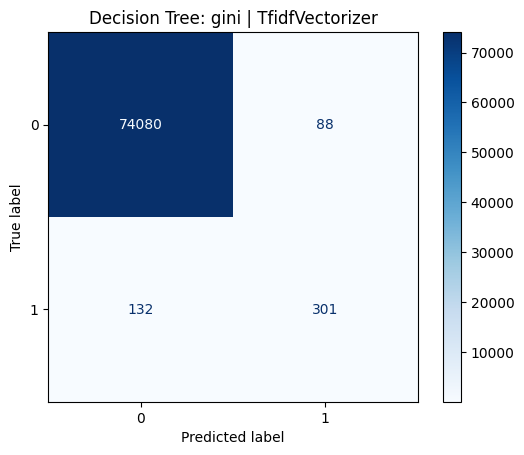

In [26]:
model = DecisionTreeClassifier(criterion='gini')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: gini | TfidfVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Decision Trees: gini-balanced | TfidfVectorizer

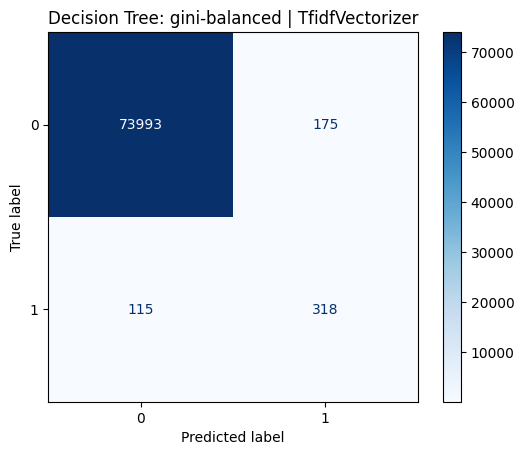

In [27]:
model = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Decision Tree: gini-balanced | TfidfVectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

### Logistic Regression

#### Logistic Regression: newton-cg | CountVectorizer

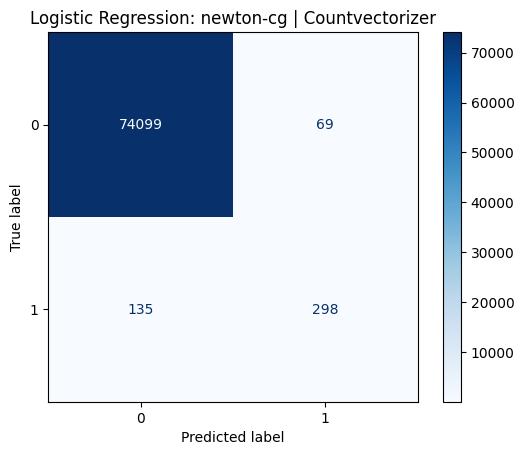

In [28]:
model = LogisticRegression(solver='newton-cg')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Logistic Regression: newton-cg | Countvectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Logistic Regression: newton-cg | balanced | CountVectorizer

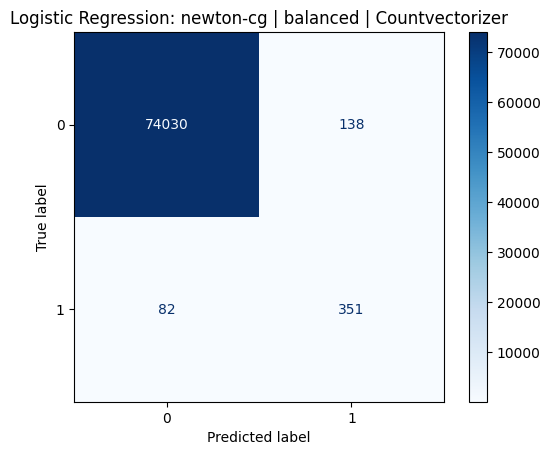

In [29]:
model = LogisticRegression(solver='newton-cg',class_weight='balanced')

start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Logistic Regression: newton-cg | balanced | Countvectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Logistic Regression: newton-cg | TfidfVectorizer

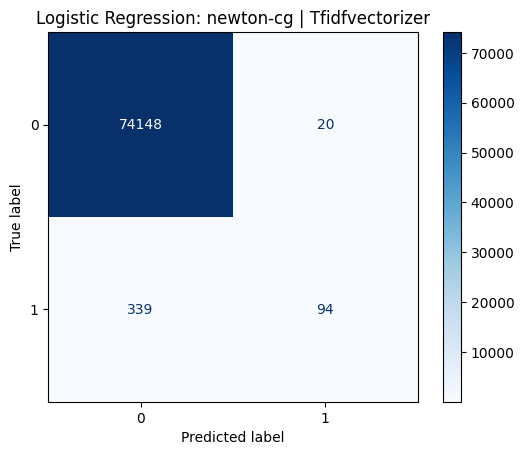

In [30]:
model = LogisticRegression(solver='newton-cg')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Logistic Regression: newton-cg | Tfidfvectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

#### Logistic Regression: newton-cg | balanced | Tfidfvectorizer

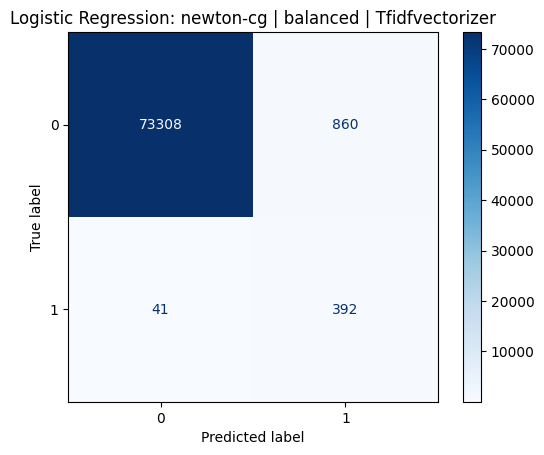

In [31]:
model = LogisticRegression(solver='newton-cg',class_weight = 'balanced')

start_time = time.time()
model.fit(x_train_tfidf,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_tfidf)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'Logistic Regression: newton-cg | balanced | Tfidfvectorizer'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

### SVM

#### SVM: kernel: linear

c:\Users\Usuario\Documents\Proyectos\DMC\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


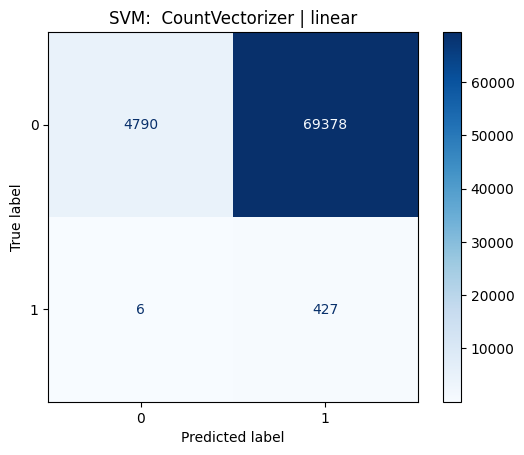

In [35]:
model = SVC(kernel='linear',max_iter=100)


start_time = time.time()
model.fit(x_train_vecto,y_train)
end_time = time.time()

train_duration = end_time - start_time

start_time = time.time()
predictions = model.predict(x_test_vecto)
end_time = time.time()

predict_duration = end_time - start_time

model_name = 'SVM:  CountVectorizer | linear'
save_info_evaluation(model_name, y_test,predictions,train_duration,predict_duration)

## 6. Conclusions

### Dataframe with all the metrics of the models

In [73]:
df = pd.DataFrame(model_description, columns=['model_name','accuracy','precision','recall','f1score',
                                            'train_duration','predict_duration','confusion_matrix'])

Nos piden:
modelo debe obtener como máximo `82 falsos negativos (FN)` y `141 falsos positivos (FP)`

In [74]:
for i in range(len(df)):
    cond = 0
    if df['confusion_matrix'][i][0][1] <= 141:
        cond += 1
    if df['confusion_matrix'][i][1][0] <= 82:
        cond+=1
    df.loc[i,'check_cond'] = cond

In [71]:
df.sort_values('check_cond',ascending=False)

,model_name,accuracy,precision,recall,f1score,train_duration,predict_duration,confusion_matrix,check_cond
11,Logistic Regression: newton-cg | balanced | Co...,0.997051,0.717791,0.810624,0.761388,152.528993,0.041005,"[[74030, 138], [82, 351]]",2.0
1,NB with TF-IDF with alpha 1e-15,0.997198,0.861290,0.616628,0.718708,0.244750,0.071484,"[[74125, 43], [166, 267]]",1.0
2,Decision Tree: entropy | CountVectorizer,0.997158,0.791557,0.692841,0.738916,90.058236,0.086102,"[[74089, 79], [133, 300]]",1.0
4,Decision Tree: entropy | TfidfVectorizer,0.997172,0.777500,0.718245,0.746699,182.346055,0.077474,"[[74079, 89], [122, 311]]",1.0
5,Decision Tree: entropy-balanced | TfidfVectorizer,0.996756,0.716553,0.729792,0.723112,142.370577,0.075831,"[[74043, 125], [117, 316]]",1.0
6,Decision Tree: gini | CountVectorizer,0.997480,0.851003,0.685912,0.759591,299.344015,0.091702,"[[74116, 52], [136, 297]]",1.0
8,Decision Tree: gini | TfidfVectorizer,0.997051,0.773779,0.695150,0.732360,678.130970,0.122023,"[[74080, 88], [132, 301]]",1.0
10,Logistic Regression: newton-cg | Countvectorizer,0.997265,0.811989,0.688222,0.745000,152.914762,0.053366,"[[74099, 69], [135, 298]]",1.0
12,Logistic Regression: newton-cg | Tfidfvectorizer,0.995188,0.824561,0.217090,0.343693,10.309901,0.027204,"[[74148, 20], [339, 94]]",1.0
13,Logistic Regression: newton-cg | balanced | Tf...,0.987922,0.313099,0.905312,0.465282,9.461586,0.023322,"[[73308, 860], [41, 392]]",1.0


#### Best model

El mejor modelo es `Logistic Regression: newton-cg | balanced | CountVectorizer`, vemos que cumple ambas condiciones, además que su entrenamiento es menor a 3 minutos, aunque hay otros modelos que se aproximan bastante, en caso de que haya más datos sería ideal probar el modelo para saber si hay overfitting o underfitting.